In [76]:
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pandas as pd
from pathlib import Path
from evaluation.cross_tool_analysis import load_proverbot, load_tactician, load_rango, get_unique_files, get_mutual_proof_pairs, NamedEval, get_two_eval_subsets, SuccessfulResult, GeneralResult

In [77]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling": 
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")

In [78]:
PROVERBOT_LOC = Path("evaluations/proverbot")
TACTICIAN_LOC = Path("evaluations/tactician/results-24-07-22")
GRAPH2TAC_LOC = Path("evaluations/graph2tac/results")
RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-prem-final")
#RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-prem-final-test-500")
#RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-final-test-500")

In [79]:
proverbot_eval = NamedEval("proverbot", load_proverbot(PROVERBOT_LOC))
tactician_eval = NamedEval("tactician", load_tactician(TACTICIAN_LOC))
graph2tac_eval = NamedEval("graph2tac", load_tactician(GRAPH2TAC_LOC))
rango_eval = NamedEval("rango", load_rango(RANGO_LOC))

In [ ]:
raw_evals = [
    proverbot_eval,
    tactician_eval,
    graph2tac_eval,
    rango_eval,
]

In [ ]:
[len(e.results) for e in raw_evals]

[10714, 1389]

In [ ]:
mutual_proofs = get_mutual_proof_pairs(raw_evals)
evals = [e.filter_results(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)

In [ ]:
[len(e.results) for e in evals]

[1220, 1220]

In [ ]:
len(mutual_proofs)

1220

In [ ]:

def attempts_by_project(e: NamedEval) -> dict[str, list[GeneralResult]]:
    grouped_results: dict[str, list[GeneralResult]] = {}
    for r in e.results: 
        project = r.file.parts[0]
        if project not in grouped_results:
            grouped_results[project] = []
        grouped_results[project].append(r)
    return grouped_results

def count_successes(results: list[GeneralResult]) -> int:
    return sum(1 for r in results if r.success)

rows: list[tuple[str, str, int, int, float, str]] = []
for e in raw_evals:
    attempts_by_proj = attempts_by_project(e)
    for proj, attempts in attempts_by_project(e).items():
        n_successes = count_successes(attempts)
        n_attempts = len(attempts)
        p = n_successes / n_attempts
        p_str = f"{p:.3f} ({n_successes}/{n_attempts})"
        rows.append((e.name, proj, n_successes, n_attempts, p, p_str))
total_df = pd.DataFrame(rows, columns=["System", "Project", "Successes", "Attempts", "Success Rate [f]", "Success Rate"])

In [ ]:
system_cols = total_df.set_index(["Project", "System"])["Success Rate"].unstack()
system_cols.loc[~pd.isna(system_cols["tactician"])]

System,rango,tactician
Project,,
CompCert,0.28 (209/743),0.24 (1304/5330)
PolTac,0.77 (30/39),0.85 (264/309)
buchberger,0.17 (13/77),0.23 (149/658)
coq-ext-lib,0.50 (13/26),0.58 (132/227)
dblib,0.42 (8/19),0.47 (96/203)
fourcolor,0.19 (31/162),0.05 (70/1494)
hoare-tut,NaN,0.22 (2/9)
huffman,0.12 (4/34),0.22 (59/270)
math-classes,0.34 (63/186),0.34 (512/1501)


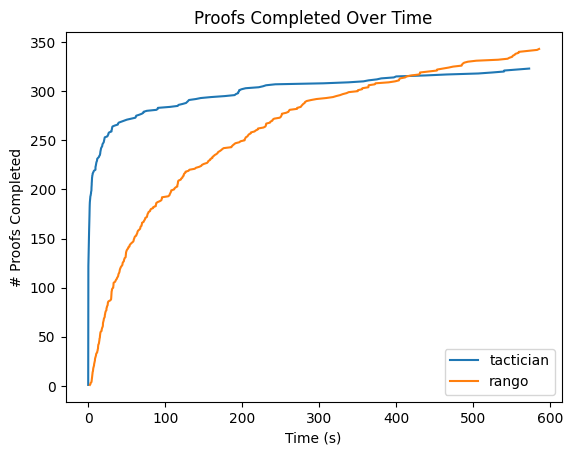

In [ ]:
def plot_times(es: list[NamedEval]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.name)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

Total # Found =  440


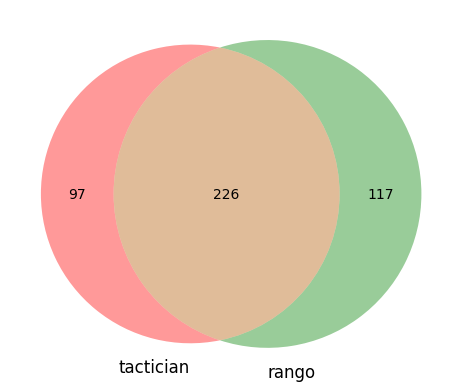

In [ ]:
def compare_two(es: list[NamedEval], e1_alias: str, e2_alias: str) -> int:
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
          set_labels=(e1_alias, e2_alias), ax=ax)
    get_two_eval_subsets(es, e1_alias, e2_alias)
    return len(subsets.one_only) + len(subsets.one_two) + len(subsets.two_only)


total_found = compare_two(evals, "tactician", "rango")
print("Total # Found = ", total_found)




In [ ]:
subsets = get_two_eval_subsets(evals, "tactician", "rango")

In [ ]:
import json
with open("tactician_only.json", "w") as fout:
    fout.write(json.dumps([{"file": str(s.file), "theorem": s.theorem} for s in subsets.one_only], indent=2))